# benchmarking on sergio


In [13]:
from bengrn import BenGRN
import scanpy as sc

from scdataloader import Preprocessor

from anndata.utils import make_index_unique
from bengrn import compute_genie3
from grnndata import utils as grnutils
from grnndata import read_h5ad
import numpy as np
import pandas as pd

from scdataloader import utils as data_utils

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#genes = torch.load('/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', map_location=torch.device('cpu'))['hyper_parameters']['genes']

genes = torch.load('../data/temp/vbd8bavn/epoch=17-step=90000.ckpt')['hyper_parameters']['genes']

In [14]:
adata = read_h5ad("../tools/SERGIO/sergio_gt_grn.h5ad")
adata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
genesdf = data_utils.load_genes(adata.obs.organism_ontology_term_id.iloc[0])
adata

ValueError: GRN not found in adata.varp

In [7]:
# Merge adata.var with genesdf
# First, ensure the index of adata.var is named
adata.var.index.name = 'symbol'

# Merge adata.var with genesdf
# Merge adata.var with genesdf, keeping only the first instance of each symbol
merged_var = adata.var.reset_index().merge(
    genesdf.reset_index().drop_duplicates(subset='symbol', keep='first'),
    left_on='symbol',
    right_on='symbol',
    how='left'
)

# Set the index back to 'symbol'
merged_var.set_index('symbol', inplace=True)
adata.var = merged_var
adata.var['symbol'] =  adata.var.index

In [8]:
subadata = adata[:, adata.var.ensembl_gene_id.isin(genes)].copy()
del subadata.varp['GRN']

Tree method: RF
K: sqrt
Number of trees: 1000


running jobs on 20 threads
Elapsed time: 137.75 seconds
precision:  0.03313367792618938 
recall:  0.9857558139534883 
random precision: 0.0324932935353459


  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 2336.10it/s]


Average Precision (AP):  0.03449673635925644
Area Under Precision-Recall Curve (AUPRC):  0.03442043400282878
EPR: 0.9449787307085673


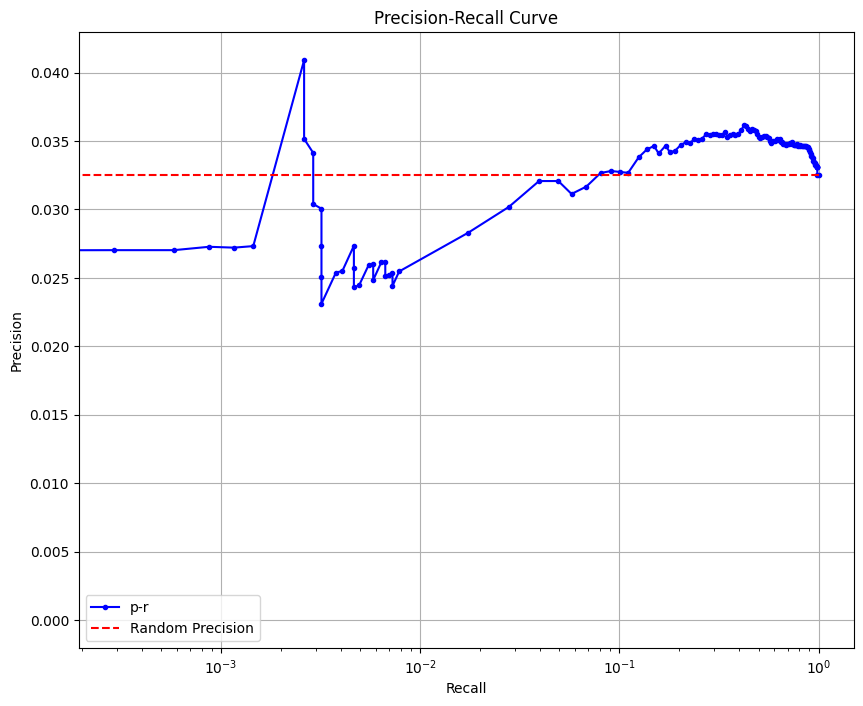

{'precision': 0.03313367792618938,
 'recall': 0.9857558139534883,
 'rand_precision': 0.0324932935353459,
 'auprc': 0.03442043400282878,
 'ap': 0.03449673635925644,
 'epr': 0.9449787307085673}

In [11]:
# normal
genie_grn = compute_genie3(subadata, nthreads=20, ntrees=1000)
genie_grn.var.index = subadata.var.index
BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=adata)

base enrichment
Top central genes: []


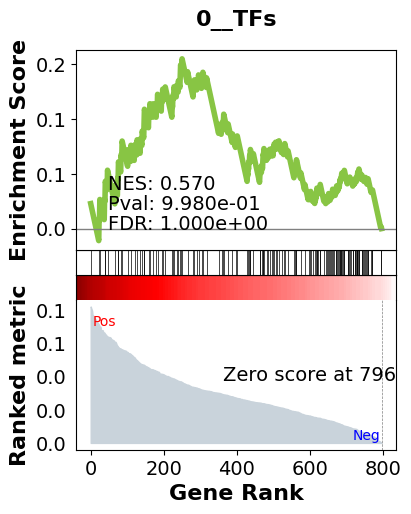

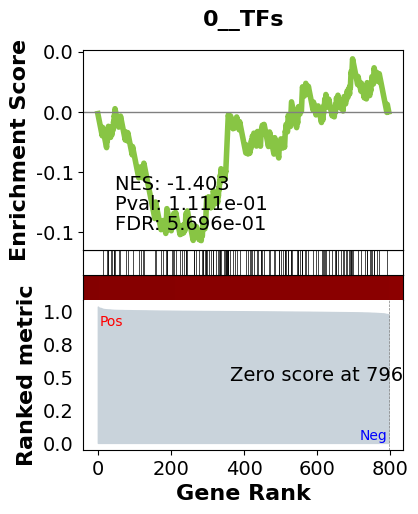

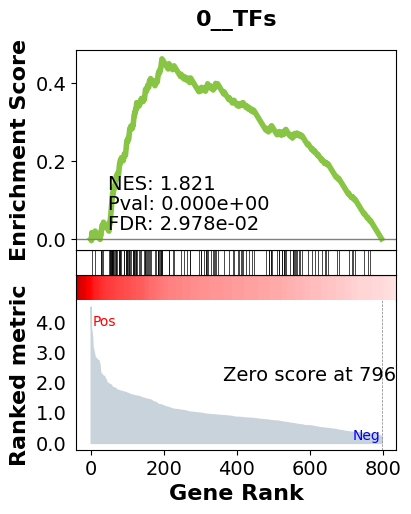

_________________________________________
TF specific enrichment
found some significant results for  5.2631578947368425 % TFs

_________________________________________
loading GT,  omnipath
intersection of 652 genes
intersection pct: 0.8180677540777918
precision:  0.025529625327480175 
recall:  0.9672318536864165 
random precision: 0.024733067578901737


 70%|██████▉   | 89/128 [00:00<00:00, 889.31it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 851.44it/s]


Average Precision (AP):  0.03132124271575136
Area Under Precision-Recall Curve (AUPRC):  0.03126779800722937
EPR: 1.2307138733467702


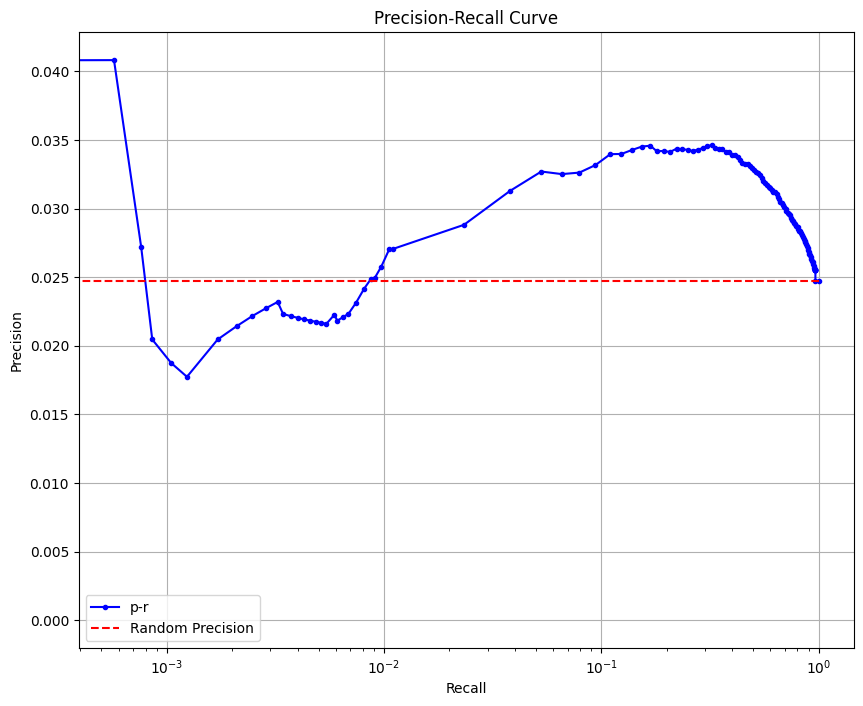

{'TF_enr': True,
 'enriched_terms_Targets': ['celltype.gmt__Langerhans cells', '0__TFs'],
 'significant_enriched_TFtargets': 5.2631578947368425,
 'precision': 0.025529625327480175,
 'recall': 0.9672318536864165,
 'rand_precision': 0.024733067578901737,
 'auprc': 0.03126779800722937,
 'ap': 0.03132124271575136,
 'epr': 1.2307138733467702}

In [12]:
genie_grn.var.index = make_index_unique(genie_grn.var['symbol'].astype(str))
BenGRN(genie_grn).scprint_benchmark()